#### This notebook shows how to use the ray tracers to compute the forward operator for pulse-echo ultrasound tomography

Each row of the forward operator $\mathbf{F}$ can be used to solve the line integral

\begin{equation}
t = \int_{L} s(x, z) dl,
\end{equation}

where $t$ is the time of flight, $s$ is the slowness, $L$ refers to the ray connecting the ultrasound probe to each pixel, and $dl$ is the differential arc length along the ray. Here, we consider transmissions of both steered plane waves and diverging waves. In matrix notation, this equation can be expressed as

\begin{equation}
\mathbf{d} = \mathbf{F} \mathbf{m},
\end{equation}

where $d$ is a vector containing $t$ measurements, $\mathbf{m}$ contains the values of $s$ at each grid point, and $\mathbf{F}$ is the forward operator. 

Author: Naiara Korta Martiartu\
email: naiara.korta@unibe.ch\
Date: March 2024

In [1]:
## import useful packages

import numpy as np
import math
import matplotlib.pyplot as plt
from ray_tracers import ray_tracer_bilint, ray_tracer_pixel, ray_tracer_div_pixel, ray_tracer_div_bilint
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm_notebook

import matplotlib

matplotlib.rcParams.update({'font.size': 10})

#### Define probe properties

In [2]:
# Define probe properties

nelem = 128           # number of transducer elements
pitch = 0.2e-3        # inter-element spacing [m]

# x-position of transducer elements:

xelems = (np.arange(0, nelem) - 0.5 * (nelem - 1)) * pitch 

#### Define the grid

In [3]:
grid_def = 0  # 0: grid points at the center of pixels; 1: grid points at vertices of pixels

# Define grid dimensions

x_min, x_max = xelems[0], xelems[-1]          # minimum and maximum x-position [m]
z_min, z_max = 0, 4e-2                        # and maximumminimum z-position [m]
dx = 0.5e-3                                   # grid spacing in x-direction [m]
dz = dx                                       # grid spacing in z-direction [m]
nx = math.ceil((x_max - x_min)/dx) + 1        # number of grid points in x
nz = math.ceil((z_max - z_min)/dz) + 1        # number of grid points in z


# Define grid points along x and z

x = np.arange(0, nx) * dx - 0.5 * (nx - 1) * dx
z = np.arange(0, nz) * dz + 0.5 * dz if grid_def is 0 else np.arange(0, nz) * dz

# Create meshgrid

xx, zz = np.meshgrid(x, z)

xx = xx.reshape(-1)
zz = zz.reshape(-1)

## 1.- Trasnmission: Plane Waves

#### Define transmit steering angles 

In [4]:
angle_i, angle_f = -25, 25    # Minimum and maximu angle [deg]
dangle = 2.5                  # Angle step [deg]

angles = np.arange(angle_i, angle_f + dangle, dangle) * np.pi / 180  # [rad]

nangles = len(angles)  # Number of angles

#### Define ray tracer

In [5]:
if grid_def:
    tracer = ray_tracer_bilint
else:
    tracer = ray_tracer_pixel

#### Compute forward operator

In [6]:
# initialize forward operator

forward_op = [0] * nangles


if nangles % 2 == 0:  # if number of angles is even (there is no angle = 0)

    ind = int(nangles / 2)  # take half of the angles

    for i, angle in enumerate(tqdm_notebook(angles[0: ind])):  # loop over these angles

        # compute non-zero elements of sparse matrices with ray paths for angle and -angle
        vals, ind_row, ind_col, ind_row_neg, ind_col_neg = tracer(angle, xx, zz, x[[0, -1]], dx, dz, nx, nz)

        # matrix for angle
        forward_op[i] = csr_matrix((vals, (ind_row, ind_col)), shape=(nx * nz, nx * nz))  

        # matrix for -angle
        forward_op[-i - 1] = csr_matrix((vals, (ind_row_neg, ind_col_neg)), shape=(nx * nz, nx * nz))  

else:  # if number of angles is even (there is angle = 0)

    ind = int((nangles - 1) / 2)  # take half of the angles except angle = 0

    for i, angle in enumerate(tqdm_notebook(angles[0: ind])):  # loop over these angles

        # compute non-zero elements of sparse matrices with ray paths for angle and -angle
        vals, ind_row, ind_col, ind_row_neg, ind_col_neg = tracer(angle, xx, zz, x[[0, -1]], dx, dz, nx, nz)

        # matrix for angle
        forward_op[i] = csr_matrix((vals, (ind_row, ind_col)), shape=(nx * nz, nx * nz)) 

        # matrix for -angle
        forward_op[-i - 1] = csr_matrix((vals, (ind_row_neg, ind_col_neg)), shape=(nx * nz, nx * nz))

    # compute ray paths for angle = 0
    vals, ind_row, ind_col, _, _ = tracer(angles[ind], xx, zz, x[[0, -1]], dx, dz, nx, nz, neg=False)

    forward_op[ind] = csr_matrix((vals, (ind_row, ind_col)), shape=(nx * nz, nx * nz)) 

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# compute ray paths for angle = 0
vals, ind_row, ind_col, _, _ = tracer(angles[ind], xx, zz, x[[0, -1]], dx, dz, nx, nz, neg=False)

#### Plot ray paths

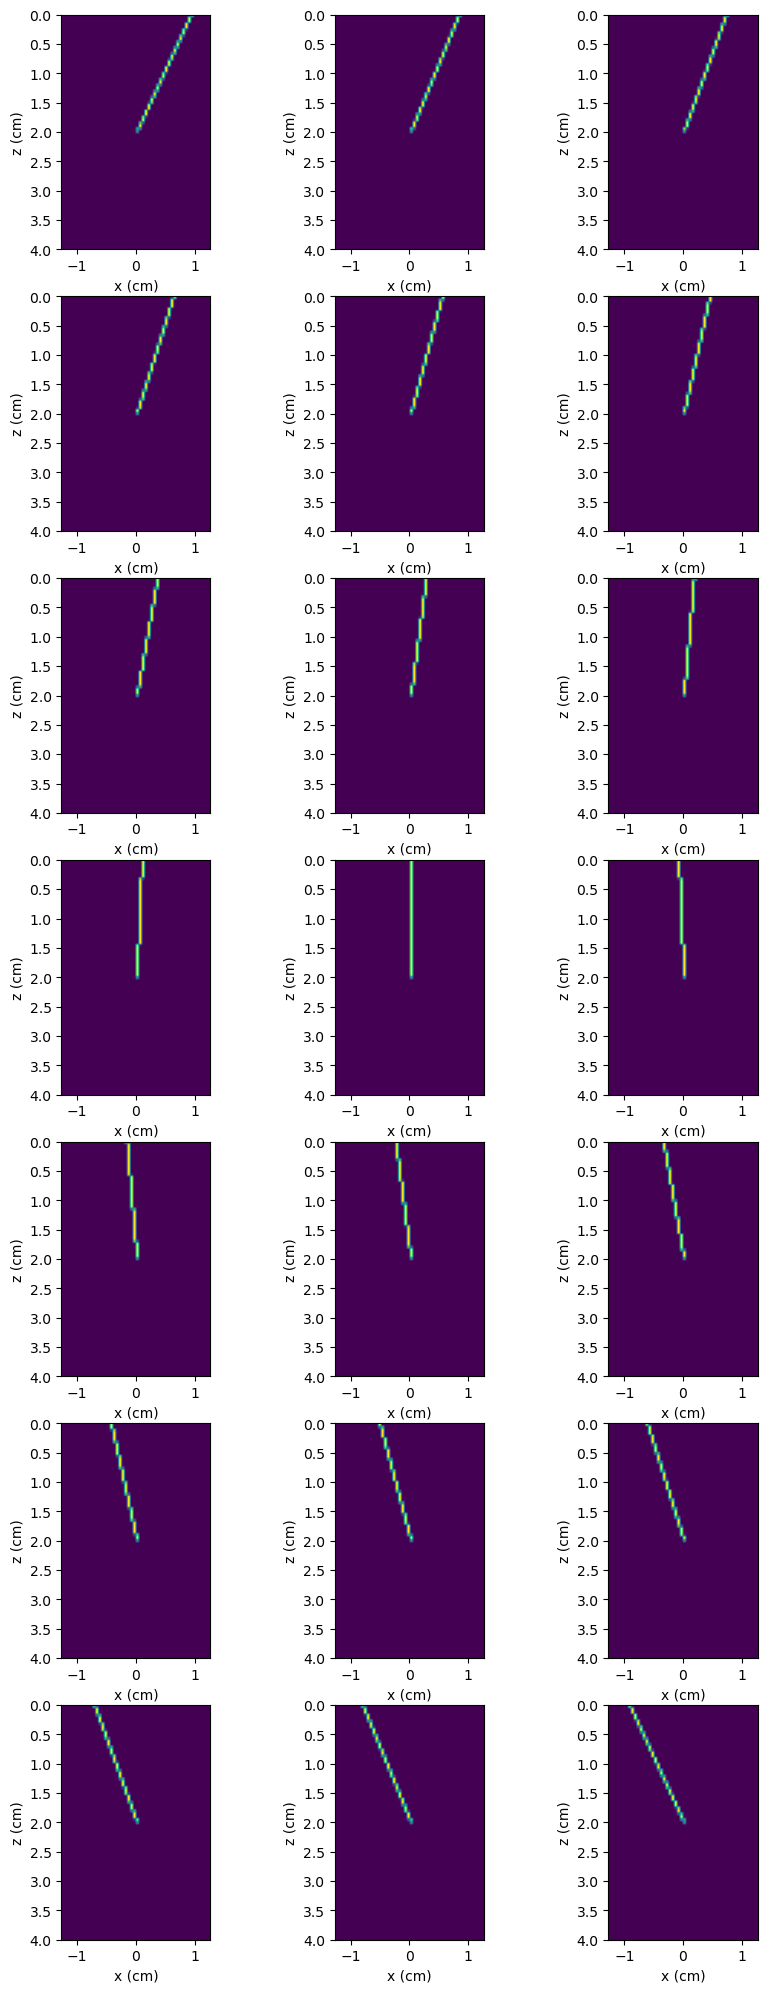

In [8]:
# Define pixel of interest (virtual receiver)

xr, zr = 0, 2e-2  # [m]

indx, indz = round((xr-x[0])/dx), round((zr-z[0])/dz)  # indices of corresponding grid points

ind = indz * nx + indx  # global index

# Plot

fig = plt.figure(figsize=(10,25))

extent = 100*x_min, 100*x_max, 100*z_max, 100*z_min

for i in range(nangles):
    
    ax = fig.add_subplot(7, 3, i + 1)
    
    ax.imshow(forward_op[i][ind, :].reshape((nz, nx)).toarray(), extent=extent)
    plt.xlabel('x (cm)')
    plt.ylabel('z (cm)')

#### Plot ray density

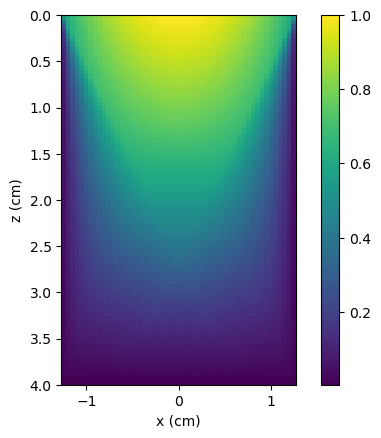

In [9]:
ray_density = np.zeros((1, nz * nx))

for i in range(nangles):
    
    ray_density += np.sum(forward_op[i], axis=0)
    
plt.imshow(ray_density.reshape((nz, nx))/np.max(ray_density), extent=extent)
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar()

## 2.- Transmission: Diverging waves

#### Define ray tracer

In [10]:
if grid_def:
    tracer = ray_tracer_div_bilint
else:
    tracer = ray_tracer_div_pixel

#### Compute forward operator

In [11]:
# initialize forward operator

forward_op = [0] * nelem

ind = int(nelem / 2)  # take half of the elements (typically number of elements is even)

for iel, xel in enumerate(tqdm_notebook(xelems[:ind])):  # loop over these elements

    # compute non-zero elements of sparse matrices with ray paths for xel and -xel
    vals, ind_row, ind_col, ind_row_neg, ind_col_neg = tracer(xel, xx, zz, x[[0, -1]], dx, dz, nx, nz, neg=True)

    # build sparse matrix for xel
    forward_op[iel] = csr_matrix((vals, (ind_row, ind_col)), shape=(nx * nz, nx * nz))  
    
    # build sparse matrix for -xel
    forward_op[-iel - 1] = csr_matrix((vals, (ind_row_neg, ind_col_neg)), shape=(nx * nz, nx * nz)) 

  0%|          | 0/64 [00:00<?, ?it/s]

#### Plot ray paths

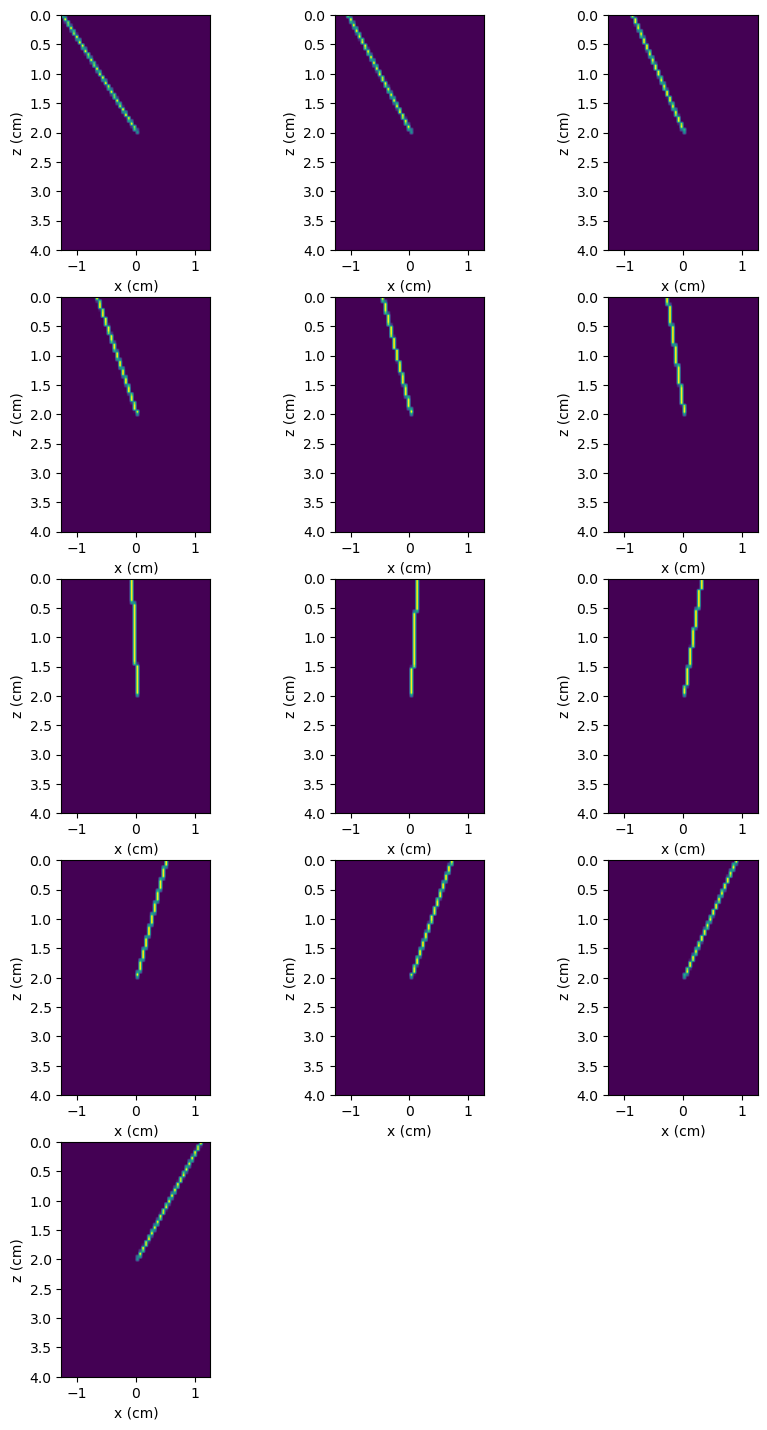

In [12]:
# Define pixel of interest (virtual receiver)

xr, zr = 0, 2e-2  # [m]

indx, indz = round((xr-x[0])/dx), round((zr-z[0])/dz)  # indices of corresponding grid points

ind = indz * nx + indx  # global index

# Plot

fig = plt.figure(figsize=(10,25))

extent = 100*x_min, 100*x_max, 100*z_max, 100*z_min

k = 1
for i in range(0,nelem,10):
    
    ax = fig.add_subplot(7, 3, k)
    k += 1
    
    ax.imshow(forward_op[i][ind, :].reshape((nz, nx)).toarray(), extent=extent)
    plt.xlabel('x (cm)')
    plt.ylabel('z (cm)')

#### Plot ray density

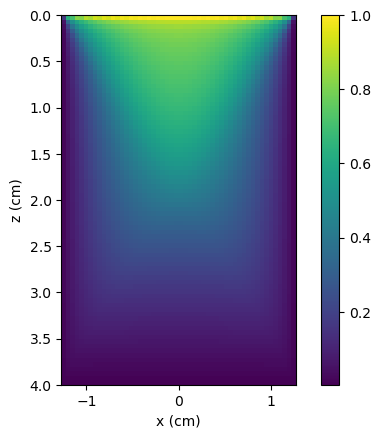

In [13]:
ray_density = np.zeros((1, nz * nx))

for i in range(nelem):
    
    ray_density += np.sum(forward_op[i], axis=0)
    
plt.imshow(ray_density.reshape((nz, nx))/np.max(ray_density), extent=extent)
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar()